<a href="https://colab.research.google.com/github/nonyeezeh/Research-Project-Code/blob/main/code_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from tabulate import tabulate
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import HillClimbSearch, BicScore, MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination
from scipy.stats import entropy

# 1

Generate different distributions, denoted "P$*$", ranging from sparse\(Tree-like structures with fewer connections between nodes) to dense(Complex models that are almost fully connected, where most nodes have many edges) distributions. These distributions will be captured in a graph-structure, ``G*" with a set of nodes and edges.

# 2

Generate training datasets of various sizes, D = $\{d_1, d_2, \dots, d_m\}$, with sample sizes at intervals of k = 100,200,…,1000. The data will be split into test, training and validation.

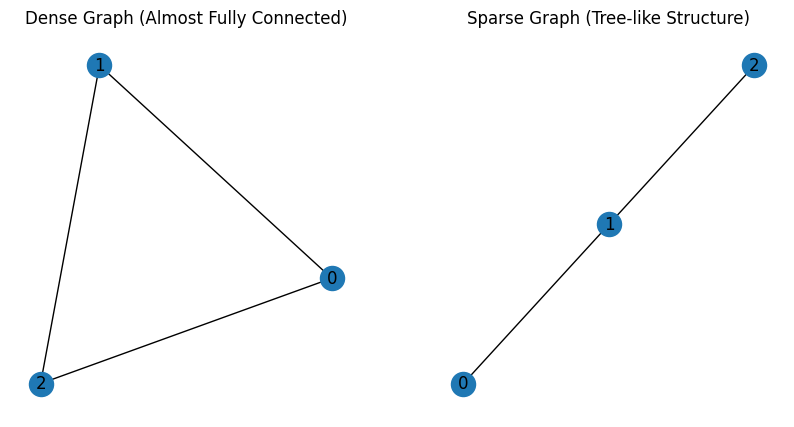


Generating data for 100 samples...
Sparse Distribution (100 samples):
╒════╤════════════════════╤═════════════╤════════════════════╤═════════════╤════════════════════╤═════════════╕
│    │ IR_Probabilities   │ Chosen_IR   │ EI_Probabilities   │ Chosen_EI   │ SP_Probabilities   │ Chosen_SP   │
╞════╪════════════════════╪═════════════╪════════════════════╪═════════════╪════════════════════╪═════════════╡
│  0 │ 0.22,0.63,0.15     │ medium      │ 0.81,0.17,0.02     │ poor        │ 0.27,0.52,0.21     │ stable      │
├────┼────────────────────┼─────────────┼────────────────────┼─────────────┼────────────────────┼─────────────┤
│  1 │ 0.06,0.48,0.46     │ medium      │ 0.66,0.09,0.25     │ poor        │ 0.33,0.39,0.27     │ stable      │
├────┼────────────────────┼─────────────┼────────────────────┼─────────────┼────────────────────┼─────────────┤
│  2 │ 0.33,0.02,0.65     │ high        │ 0.76,0.02,0.22     │ poor        │ 0.04,0.19,0.77     │ increase    │
├────┼────────────────────┼──────

In [81]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tabulate import tabulate

# Generate Dense Graph
def generate_dense_graph(num_nodes=3):
    dense_graph = nx.dense_gnm_random_graph(n=num_nodes, m=int(num_nodes*(num_nodes-1)/2))  # Max edges
    return dense_graph

# Generate Sparse Graph
def generate_sparse_graph(num_nodes=3):
    sparse_graph = nx.random_tree(n=num_nodes)  # Generate a random tree with fewer edges and dependencies
    return sparse_graph

# Visualize dense and sparse graphs side by side
def visualize_graphs():
    dense_graph = generate_dense_graph(num_nodes=3)
    sparse_graph = generate_sparse_graph(num_nodes=3)

    # Create subplots
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Plot dense graph
    nx.draw(dense_graph, with_labels=True, ax=axs[0])
    axs[0].set_title("Dense Graph (Almost Fully Connected)")

    # Plot sparse graph
    nx.draw(sparse_graph, with_labels=True, ax=axs[1])
    axs[1].set_title("Sparse Graph (Tree-like Structure)")

    # Show plots
    plt.show()

# Visualize the graphs once
visualize_graphs()

# Assuming 'values' dictionary is already defined
values = {
    'IR': ['low', 'medium', 'high'],
    'EI': ['poor', 'average', 'good'],
    'SP': ['decrease', 'stable', 'increase']
}

# Functions to generate random probabilities
def sample_random_variable(possible_values):
    probabilities = np.random.dirichlet(np.ones(len(possible_values)))
    rounded_probs = [round(p, 2) for p in probabilities]
    chosen_index = np.argmax(probabilities)
    chosen_value = possible_values[chosen_index]
    return chosen_value, rounded_probs

# Function to generate SP based on random influences from IR and EI
def sample_SP(ir=None, ei=None):
    probabilities = np.random.dirichlet(np.ones(len(values['SP'])))
    rounded_probs = [round(p, 2) for p in probabilities]
    chosen_index = np.argmax(probabilities)
    chosen_value = values['SP'][chosen_index]
    return chosen_value, rounded_probs

# Data generation with sparse or dense relationships, also capturing probabilities
def generate_data_with_structure(num_samples=100, structure='sparse'):
    data = []
    probabilities_data = []

    for _ in range(num_samples):
        ir, ir_probs = sample_random_variable(values['IR'])
        ei, ei_probs = sample_random_variable(values['EI'])

        if structure == 'sparse':
            # Only one variable influences SP (sparse)
            if np.random.rand() > 0.5:
                sp, sp_probs = sample_SP(ir, None)  # IR influences SP
            else:
                sp, sp_probs = sample_SP(None, ei)  # EI influences SP
        elif structure == 'dense':
            # Both IR and EI influence SP (dense)
            sp, sp_probs = sample_SP(ir, ei)

        data.append([ir, ei, sp])
        probabilities_data.append([
            ','.join(map(str, ir_probs)),
            ir,
            ','.join(map(str, ei_probs)),
            ei,
            ','.join(map(str, sp_probs)),
            sp
        ])

    return data, probabilities_data

# Define sample sizes
sample_sizes = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

# Loop over each sample size to generate sparse and dense datasets
for num_samples in sample_sizes:
    print(f"\nGenerating data for {num_samples} samples...")

    # Generate sparse and dense datasets
    sparse_data, sparse_probabilities = generate_data_with_structure(num_samples=num_samples, structure='sparse')
    dense_data, dense_probabilities = generate_data_with_structure(num_samples=num_samples, structure='dense')

    # Convert to DataFrame for easier handling
    sparse_df = pd.DataFrame(sparse_data, columns=['IR', 'EI', 'SP'])
    dense_df = pd.DataFrame(dense_data, columns=['IR', 'EI', 'SP'])

    # Convert probabilities to DataFrame for each dataset
    sparse_probs_df = pd.DataFrame(sparse_probabilities, columns=[
        'IR_Probabilities', 'Chosen_IR',
        'EI_Probabilities', 'Chosen_EI',
        'SP_Probabilities', 'Chosen_SP'
    ])

    dense_probs_df = pd.DataFrame(dense_probabilities, columns=[
        'IR_Probabilities', 'Chosen_IR',
        'EI_Probabilities', 'Chosen_EI',
        'SP_Probabilities', 'Chosen_SP'
    ])

    # Save the data and probabilities to CSV files with sample size in the filename
    #sparse_df.to_csv(f'sparse_bn_data_{num_samples}.csv', index=False)
    sparse_probs_df.to_csv(f'sparse_bn_probabilities_{num_samples}.csv', index=False)

    #dense_df.to_csv(f'dense_bn_data_{num_samples}.csv', index=False)
    dense_probs_df.to_csv(f'dense_bn_probabilities_{num_samples}.csv', index=False)

    # Print confirmation and display first few rows of each
    print(f"Sparse Distribution ({num_samples} samples):")
    print(tabulate(sparse_probs_df.head(), headers='keys', tablefmt='fancy_grid'))

    print(f"Dense Distribution ({num_samples} samples):")
    print(tabulate(dense_probs_df.head(), headers='keys', tablefmt='fancy_grid'))

# 3

The control experiment/model will be a Bayesian Network where both the structure and parameters are learned from the data, using appropriate priors to guide the parameter learning process.

Learned Structure: The structure of the Bayesian Network (the relationships between the variables) will be learned from the data.

Learned Parameters: The parameters (conditional probability distributions) will also be learned from the data, but with priors influencing the learning process. Priors are initial assumptions made about the parameters before observing the data, and these guide the learning.

In [85]:
import pandas as pd
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import HillClimbSearch, BicScore, MaximumLikelihoodEstimator

# Function to learn Bayesian Network from chosen values in the dataset
def learn_bayesian_network(data, dataset_name, sample_size):
    # Step 1: Learn the structure using HillClimbSearch with BIC scoring
    hc = HillClimbSearch(data)
    best_model = hc.estimate(scoring_method=BicScore(data))

    # Step 2: Create a Bayesian Network model with the learned structure
    model = BayesianNetwork(best_model.edges())

    # Step 3: Fit the parameters (CPDs) to the learned structure using Maximum Likelihood Estimation
    model.fit(data, estimator=MaximumLikelihoodEstimator)

    # Step 4: Print the learned structure and CPDs
    print(f"\nLearned Structure for {dataset_name} with {sample_size} samples:")
    print(model.edges())

    for cpd in model.get_cpds():
        print(f"\nCPD for {cpd.variable}:")
        print(cpd)

    return model

# Define sample sizes
sample_sizes = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

# Loop through each sample size
for num_samples in sample_sizes:
    print(f"\nProcessing {num_samples} samples...")

    # Load the sparse and dense data for this sample size
    sparse_data = pd.read_csv(f'sparse_bn_probabilities_{num_samples}.csv')
    dense_data = pd.read_csv(f'dense_bn_probabilities_{num_samples}.csv')

    # Use only the 'Chosen' columns for learning the Bayesian Network structure and parameters
    sparse_bn_data = sparse_data[['Chosen_IR', 'Chosen_EI', 'Chosen_SP']]
    dense_bn_data = dense_data[['Chosen_IR', 'Chosen_EI', 'Chosen_SP']]

    # Learn the Bayesian Network for both sparse and dense datasets
    sparse_bn = learn_bayesian_network(sparse_bn_data, "Sparse Data", num_samples)
    dense_bn = learn_bayesian_network(dense_bn_data, "Dense Data", num_samples)

    # (Optional) You can load and print the probabilities after learning the structure
    print("\nSparse Data Probabilities (first few rows):")
    print(sparse_data[['IR_Probabilities', 'EI_Probabilities', 'SP_Probabilities']].head())

    print("\nDense Data Probabilities (first few rows):")
    print(dense_data[['IR_Probabilities', 'EI_Probabilities', 'SP_Probabilities']].head())


Processing 100 samples...


  0%|          | 0/1000000 [00:00<?, ?it/s]


Learned Structure for Sparse Data with 100 samples:
[]


  0%|          | 0/1000000 [00:00<?, ?it/s]


Learned Structure for Dense Data with 100 samples:
[]

Sparse Data Probabilities (first few rows):
  IR_Probabilities EI_Probabilities SP_Probabilities
0   0.22,0.63,0.15   0.81,0.17,0.02   0.27,0.52,0.21
1   0.06,0.48,0.46   0.66,0.09,0.25   0.33,0.39,0.27
2   0.33,0.02,0.65   0.76,0.02,0.22   0.04,0.19,0.77
3   0.49,0.51,0.01   0.17,0.27,0.55   0.22,0.12,0.66
4   0.09,0.28,0.63   0.07,0.62,0.31   0.12,0.81,0.07

Dense Data Probabilities (first few rows):
  IR_Probabilities EI_Probabilities SP_Probabilities
0   0.22,0.76,0.02   0.41,0.06,0.53   0.35,0.22,0.44
1   0.09,0.43,0.48    0.1,0.45,0.44    0.14,0.8,0.06
2   0.08,0.39,0.53   0.04,0.03,0.93   0.49,0.14,0.37
3    0.2,0.43,0.37    0.53,0.46,0.0   0.08,0.37,0.55
4   0.55,0.27,0.18   0.38,0.08,0.54   0.23,0.72,0.05

Processing 200 samples...


  0%|          | 0/1000000 [00:00<?, ?it/s]


Learned Structure for Sparse Data with 200 samples:
[]


  0%|          | 0/1000000 [00:00<?, ?it/s]


Learned Structure for Dense Data with 200 samples:
[]

Sparse Data Probabilities (first few rows):
  IR_Probabilities EI_Probabilities SP_Probabilities
0   0.33,0.16,0.51    0.73,0.1,0.17   0.13,0.18,0.69
1    0.1,0.03,0.87   0.24,0.37,0.39   0.01,0.68,0.31
2    0.32,0.5,0.18   0.57,0.21,0.22   0.43,0.01,0.56
3    0.15,0.85,0.0    0.35,0.15,0.5     0.2,0.59,0.2
4    0.43,0.0,0.57   0.65,0.03,0.32   0.13,0.16,0.71

Dense Data Probabilities (first few rows):
  IR_Probabilities EI_Probabilities SP_Probabilities
0   0.34,0.48,0.17   0.28,0.23,0.49    0.14,0.3,0.56
1   0.21,0.18,0.61      0.2,0.2,0.6   0.41,0.28,0.31
2    0.06,0.55,0.4    0.53,0.27,0.2   0.73,0.16,0.11
3   0.45,0.14,0.41   0.06,0.85,0.09    0.12,0.38,0.5
4    0.9,0.04,0.06   0.07,0.26,0.66    0.49,0.31,0.2

Processing 300 samples...


  0%|          | 0/1000000 [00:00<?, ?it/s]


Learned Structure for Sparse Data with 300 samples:
[]


  0%|          | 0/1000000 [00:00<?, ?it/s]


Learned Structure for Dense Data with 300 samples:
[]

Sparse Data Probabilities (first few rows):
  IR_Probabilities EI_Probabilities SP_Probabilities
0    0.1,0.23,0.66   0.27,0.72,0.01   0.16,0.59,0.25
1   0.24,0.75,0.02   0.91,0.06,0.04   0.16,0.26,0.58
2   0.68,0.26,0.06    0.18,0.4,0.43   0.01,0.56,0.43
3   0.53,0.21,0.26   0.33,0.21,0.46   0.18,0.46,0.35
4    0.3,0.29,0.41    0.3,0.59,0.11   0.36,0.63,0.01

Dense Data Probabilities (first few rows):
  IR_Probabilities EI_Probabilities SP_Probabilities
0   0.04,0.65,0.31   0.06,0.92,0.02   0.46,0.28,0.26
1    0.61,0.09,0.3   0.53,0.16,0.31   0.35,0.01,0.63
2   0.35,0.29,0.36    0.8,0.02,0.18   0.82,0.13,0.05
3    0.56,0.44,0.0   0.09,0.63,0.28    0.19,0.0,0.81
4   0.96,0.02,0.02   0.42,0.15,0.43   0.48,0.44,0.08

Processing 400 samples...


  0%|          | 0/1000000 [00:00<?, ?it/s]


Learned Structure for Sparse Data with 400 samples:
[]


  0%|          | 0/1000000 [00:00<?, ?it/s]


Learned Structure for Dense Data with 400 samples:
[]

Sparse Data Probabilities (first few rows):
  IR_Probabilities EI_Probabilities SP_Probabilities
0   0.45,0.45,0.09   0.34,0.39,0.27    0.3,0.17,0.52
1    0.32,0.58,0.1   0.67,0.23,0.09   0.08,0.44,0.49
2    0.2,0.01,0.79    0.4,0.49,0.11    0.05,0.4,0.55
3   0.04,0.67,0.29   0.07,0.61,0.32   0.41,0.37,0.22
4   0.04,0.38,0.58    0.45,0.4,0.15   0.31,0.01,0.68

Dense Data Probabilities (first few rows):
  IR_Probabilities EI_Probabilities SP_Probabilities
0   0.04,0.25,0.71    0.41,0.2,0.39    0.5,0.26,0.25
1   0.05,0.74,0.21   0.73,0.02,0.25   0.29,0.56,0.15
2   0.25,0.28,0.47   0.13,0.38,0.49   0.59,0.07,0.34
3   0.04,0.41,0.56   0.81,0.08,0.12   0.44,0.19,0.37
4   0.43,0.55,0.02   0.34,0.59,0.06   0.84,0.08,0.08

Processing 500 samples...


  0%|          | 0/1000000 [00:00<?, ?it/s]


Learned Structure for Sparse Data with 500 samples:
[]


  0%|          | 0/1000000 [00:00<?, ?it/s]


Learned Structure for Dense Data with 500 samples:
[]

Sparse Data Probabilities (first few rows):
  IR_Probabilities EI_Probabilities SP_Probabilities
0    0.07,0.9,0.03   0.24,0.47,0.28   0.45,0.34,0.22
1   0.19,0.81,0.01   0.45,0.14,0.41    0.38,0.4,0.22
2    0.6,0.15,0.25   0.59,0.38,0.03      0.4,0.5,0.1
3   0.29,0.65,0.06   0.16,0.58,0.27   0.52,0.37,0.12
4   0.48,0.03,0.49   0.31,0.02,0.67   0.31,0.51,0.18

Dense Data Probabilities (first few rows):
  IR_Probabilities EI_Probabilities SP_Probabilities
0   0.45,0.32,0.23   0.03,0.89,0.07   0.37,0.41,0.21
1   0.36,0.35,0.29     0.19,0.7,0.1   0.32,0.29,0.39
2   0.31,0.12,0.56    0.2,0.58,0.22   0.63,0.26,0.11
3   0.37,0.54,0.09   0.33,0.26,0.41    0.1,0.22,0.67
4    0.51,0.1,0.39    0.1,0.85,0.05   0.01,0.41,0.58

Processing 600 samples...


  0%|          | 0/1000000 [00:00<?, ?it/s]


Learned Structure for Sparse Data with 600 samples:
[]


  0%|          | 0/1000000 [00:00<?, ?it/s]


Learned Structure for Dense Data with 600 samples:
[]

Sparse Data Probabilities (first few rows):
  IR_Probabilities EI_Probabilities SP_Probabilities
0   0.19,0.32,0.49   0.55,0.15,0.29    0.12,0.3,0.58
1    0.67,0.33,0.0   0.39,0.08,0.53   0.02,0.86,0.12
2   0.13,0.54,0.33   0.16,0.48,0.37   0.08,0.03,0.89
3   0.22,0.55,0.23   0.08,0.59,0.33    0.77,0.22,0.0
4    0.14,0.7,0.15   0.32,0.52,0.15   0.33,0.56,0.11

Dense Data Probabilities (first few rows):
  IR_Probabilities EI_Probabilities SP_Probabilities
0   0.29,0.15,0.57   0.36,0.63,0.02   0.33,0.08,0.59
1    0.34,0.3,0.36    0.68,0.3,0.03   0.01,0.61,0.37
2   0.31,0.04,0.65   0.68,0.13,0.18   0.08,0.67,0.24
3   0.25,0.72,0.03   0.58,0.38,0.04   0.39,0.23,0.38
4   0.37,0.24,0.39   0.14,0.65,0.21   0.55,0.26,0.19

Processing 700 samples...


  0%|          | 0/1000000 [00:00<?, ?it/s]


Learned Structure for Sparse Data with 700 samples:
[]


  0%|          | 0/1000000 [00:00<?, ?it/s]


Learned Structure for Dense Data with 700 samples:
[]

Sparse Data Probabilities (first few rows):
  IR_Probabilities EI_Probabilities SP_Probabilities
0    0.56,0.04,0.4   0.17,0.27,0.55    0.02,0.1,0.88
1   0.23,0.25,0.52   0.27,0.19,0.54    0.15,0.5,0.36
2    0.29,0.3,0.41    0.24,0.66,0.1   0.02,0.95,0.04
3   0.42,0.01,0.58   0.38,0.34,0.28   0.09,0.32,0.59
4     0.2,0.19,0.6    0.05,0.86,0.1   0.11,0.06,0.83

Dense Data Probabilities (first few rows):
  IR_Probabilities EI_Probabilities SP_Probabilities
0   0.67,0.21,0.12    0.3,0.46,0.24    0.01,0.99,0.0
1   0.15,0.81,0.04    0.4,0.17,0.43    0.5,0.03,0.47
2   0.38,0.47,0.15    0.21,0.29,0.5   0.32,0.43,0.25
3   0.47,0.39,0.14   0.09,0.31,0.61   0.47,0.29,0.24
4   0.31,0.52,0.17   0.43,0.39,0.18   0.74,0.12,0.14

Processing 800 samples...


  0%|          | 0/1000000 [00:00<?, ?it/s]


Learned Structure for Sparse Data with 800 samples:
[]


  0%|          | 0/1000000 [00:00<?, ?it/s]


Learned Structure for Dense Data with 800 samples:
[]

Sparse Data Probabilities (first few rows):
  IR_Probabilities EI_Probabilities SP_Probabilities
0   0.38,0.49,0.13   0.09,0.27,0.63   0.17,0.37,0.45
1   0.34,0.29,0.38    0.2,0.13,0.68    0.7,0.26,0.04
2   0.16,0.07,0.77    0.18,0.6,0.22   0.45,0.09,0.46
3   0.37,0.45,0.17   0.02,0.51,0.48   0.04,0.72,0.25
4   0.39,0.33,0.29    0.35,0.24,0.4    0.4,0.07,0.53

Dense Data Probabilities (first few rows):
  IR_Probabilities EI_Probabilities SP_Probabilities
0   0.16,0.01,0.83   0.17,0.75,0.09    0.04,0.2,0.76
1    0.7,0.29,0.01   0.45,0.52,0.04   0.07,0.54,0.39
2   0.68,0.26,0.06   0.17,0.76,0.07    0.43,0.5,0.08
3   0.51,0.37,0.12   0.05,0.37,0.57   0.91,0.07,0.02
4    0.19,0.21,0.6   0.23,0.71,0.06   0.68,0.19,0.14

Processing 900 samples...


  0%|          | 0/1000000 [00:00<?, ?it/s]


Learned Structure for Sparse Data with 900 samples:
[]


  0%|          | 0/1000000 [00:00<?, ?it/s]


Learned Structure for Dense Data with 900 samples:
[]

Sparse Data Probabilities (first few rows):
  IR_Probabilities EI_Probabilities SP_Probabilities
0   0.25,0.42,0.32   0.02,0.94,0.04   0.17,0.64,0.19
1    0.67,0.03,0.3    0.05,0.25,0.7   0.82,0.14,0.04
2    0.07,0.9,0.03   0.04,0.61,0.35   0.16,0.56,0.28
3    0.56,0.24,0.2   0.27,0.67,0.05   0.23,0.74,0.02
4   0.87,0.07,0.06   0.04,0.31,0.65   0.28,0.45,0.27

Dense Data Probabilities (first few rows):
  IR_Probabilities EI_Probabilities SP_Probabilities
0   0.35,0.36,0.29   0.28,0.07,0.65   0.29,0.17,0.55
1    0.02,0.38,0.6   0.55,0.11,0.34   0.32,0.27,0.42
2    0.04,0.0,0.95   0.36,0.02,0.62   0.07,0.17,0.76
3   0.12,0.76,0.12      0.1,0.2,0.7   0.11,0.18,0.71
4   0.45,0.31,0.24   0.45,0.06,0.49   0.36,0.59,0.05

Processing 1000 samples...


  0%|          | 0/1000000 [00:00<?, ?it/s]


Learned Structure for Sparse Data with 1000 samples:
[]


  0%|          | 0/1000000 [00:00<?, ?it/s]


Learned Structure for Dense Data with 1000 samples:
[]

Sparse Data Probabilities (first few rows):
  IR_Probabilities EI_Probabilities SP_Probabilities
0   0.46,0.37,0.16   0.56,0.33,0.11   0.66,0.02,0.32
1   0.13,0.73,0.14    0.64,0.2,0.16   0.29,0.08,0.63
2   0.23,0.55,0.22   0.01,0.64,0.35   0.57,0.35,0.08
3    0.0,0.26,0.74   0.03,0.95,0.02   0.48,0.06,0.46
4    0.17,0.83,0.0    0.21,0.49,0.3    0.02,0.4,0.58

Dense Data Probabilities (first few rows):
  IR_Probabilities EI_Probabilities SP_Probabilities
0   0.02,0.07,0.91    0.0,0.72,0.28    0.05,0.35,0.6
1   0.53,0.46,0.02   0.58,0.09,0.33   0.41,0.17,0.41
2   0.12,0.37,0.51    0.4,0.04,0.56   0.26,0.61,0.13
3   0.92,0.02,0.07    0.2,0.02,0.78    0.21,0.29,0.5
4    0.11,0.18,0.7   0.27,0.54,0.19   0.21,0.52,0.27
